# TODO

- loi normale
- loi gamma
- dataset
- pénalisation lasso
- pénalisation group lasso

In [1]:
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import math

In [2]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
%matplotlib inline 

In [3]:
import numpy
numpy.seterr(all='raise')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [4]:
import perf
import metrics

In [5]:
from importlib import reload
reload(perf)

<module 'perf' from '\\\\siege.axa-fr.intraxa\\donneessiege\\User_data_PGEN\\data\\S628057\\Documents\\git\\pricing-tool\\perf.py'>

In [6]:
def rmse(generator, model, size=1000):
    values = np.zeros(size)
    for i in range(size):
        x, y, exposure = generator.get_observation()
        y_pred = model.pred(x, exposure)
        values[i] = y - y_pred
    return np.sqrt(np.sum(np.square(values)) / size)   

In [7]:
class PoissonSampleGenerator:
    
    def __init__(self, size):
        self.size = size
        self.intercept = -1
        self.coeffs = np.random.randn(size) / 10
        self.noise_factor = 1
        
    def get_observation(self):
        x = np.random.randn(self.size)
        exposure = np.random.rand(1)
        y = np.exp(self.intercept + np.inner(x, self.coeffs) + np.random.randn(1) * self.noise_factor / 100)
        y *= exposure
        return x, y, exposure

In [8]:
class Dataset:
    
    def __init__(self):
        pass

In [48]:
import pandas as pd

class TrainingFileReader:
    
    def __init__(self, filename, features, exposure, target):
        self.filename = filename
        self.features = features
        self.exposure = exposure
        self.target = target
        usecols = features + [exposure, target] + ['HAB_hab']
        self.df = pd.read_csv(filename, sep=',', usecols=usecols, dtype=str, nrows=500000)
        self.df = self.df[self.df.HAB_hab == 'A']
        #self.df['Intercept'] = 1
        #features = ['Intercept'] + features
        self.observations = pd.get_dummies(self.df[features])
        self.modalities = list(self.observations)
        self.observations[self.exposure] = self.df[self.exposure]
        self.observations[self.target] = self.df[self.target]
        train, test = train_test_split(self.observations, test_size=0.1)
        self.train = train.astype('float')
        self.test = test.astype('float')
        self.size = self.train.shape[0]
        mask = [0] * len(self.modalities)
        train_list = np.array(list(self.train))
        for i in range(len(self.modalities)):
            mask[i] = int(np.where(self.modalities[i] == train_list)[0])
        self.mask = mask
        self.exposure_index = int(np.where(exposure == train_list)[0])
        self.target_index = int(np.where(target == train_list)[0])
        self.train = self.train.as_matrix()
        self.test = self.test.as_matrix()
        self.train_data = self.train[:, self.mask]
        self.exposure_data = self.train[:, self.exposure_index]
        self.target_data = self.train[:, self.target_index]
        
    def get_observation(self):
        index = np.random.randint(self.size)
        x = self.train_data[index]
        y = self.target_data[index]
        exposure = self.exposure_data[index]
        return x, y, exposure 
    
    def pred(self, model):
        exposure = self.test[:, self.exposure_index]
        y = self.test[:, self.target_index]
        y_pred = np.exp(np.inner(self.test[:,self.mask], model.coeffs) + model.intercept + np.log(exposure))
        return (y, y_pred, exposure)

In [159]:
class PoissonImplicitSGD:
    
    def __init__(self, dataset):
        self.dataset = dataset
        self.size = dataset.train.shape[1] - 2
        self.intercept = 1
        self.coeffs = np.zeros(self.size)
        
    def fit_observation(self, x, y, exposure=0, learning_rate=0.001, p1=0.0):
        # get data 3 micros
        if exposure < 0.2:
            return
        y /= exposure
        y_pred = math.exp(self.intercept + np.inner(self.coeffs, x))  # 6 micros
        r = learning_rate * (y - y_pred)
        x_squared = np.sum(x**2) + 1 # 7 micros
        x1, x2 = 0, r
        y1 = x1 - learning_rate * (y - y_pred * math.exp(x_squared * x1)) # 1 micros
        y2 = x2 - learning_rate * (y - y_pred * math.exp(x_squared * x2)) # 1 micros
        for i in range(30): # 3 micros
            if abs(y2) < 1e-12:
                break
            x3 = (x1 * y2 - x2 * y1) / (y2 - y1)
            y3 = x3 - learning_rate * (y - y_pred * math.exp(x_squared * x3))
            x1, y1 = x2, y2
            x2, y2 = x3, y3
        self.intercept += x2 - learning_rate * p1 * np.sign(intercept)
        self.coeffs += x2 * x - learning_rate * p1 * np.sign(self.coeffs) # 4 micros
        
    def fit_all(self, dataset, learning_rate=0.001):
        x = dataset.train[:, dataset.mask]
        y = dataset.train[:, dataset.target_index]
        exposure = dataset.train[:, dataset.exposure_index]
        y_pred = np.exp(x @ self.coeffs + self.intercept + np.log(exposure))
        e = (y_pred - y)
        n = x.shape[0]
        self.intercept -= learning_rate * np.mean(e)
        self.coeffs -= learning_rate * np.mean((x.T * e).T, axis=0)
        
    def pred(self, x, exposure=0):
        return np.exp(np.inner(self.coeffs, x) + self.intercept) * exposure

In [49]:
g = TrainingFileReader('c:/data/mrh/axaf_mrh_tot_freq_tot.csv', 
                       [
                        'ddea_quant_cm_10',
                        'HAB_nb_pieces',
                        'HAB_qual',
                        'HAB_anclg',
                        'CLI_age',
                        #'POL_mtcapass',
                        'HAB_habit',
                        'CLI_sex',
                        #'POL_tr_tx_objv',
                        'POL_fract',
                        'annee',
                        'CLI_nb_enfant',
                       ], 'anpol', 'nbsinDDE')

iteration:  100000
mean: 22.6865594122 0.96903788178 0.0427141843843
rmse: 0.858037790402 0
gini: 0.237292296319
deviance: 10.5986842083
------------
iteration:  200000
mean: 21.9661915939 0.938267957964 0.0427141843843
rmse: 0.831212098089 0
gini: 0.261261992465
deviance: 10.5668229322
------------
iteration:  300000
mean: 21.2617082443 0.90817652627 0.0427141843843
rmse: 0.805053363061 0
gini: 0.272676940162
deviance: 10.5347143111
------------
iteration:  400000
mean: 20.5732923105 0.878771401144 0.0427141843843
rmse: 0.779545076253 0
gini: 0.278779040869
deviance: 10.5023476658
------------
iteration:  500000
mean: 19.9107284656 0.850470526906 0.0427141843843
rmse: 0.755063878487 0
gini: 0.282558454843
deviance: 10.4702293074
------------
iteration:  600000
mean: 19.2622495232 0.822771277788 0.0427141843843
rmse: 0.731161996739 0
gini: 0.284929180344
deviance: 10.4378043724
------------
iteration:  700000
mean: 18.6488422392 0.796570085957 0.0427141843843
rmse: 0.708619002739 0
gin

iteration:  5600000
mean: 3.84975442002 0.164439120131 0.0427141843843
rmse: 0.229675552566 0
gini: 0.311007819867
deviance: 9.07750832518
------------
iteration:  5700000
mean: 3.72964935229 0.159308930122 0.0427141843843
rmse: 0.227419633264 0
gini: 0.311141736563
deviance: 9.05862919413
------------
iteration:  5800000
mean: 3.61444958726 0.154388266118 0.0427141843843
rmse: 0.225323859771 0
gini: 0.311295135394
deviance: 9.04039595056
------------
iteration:  5900000
mean: 3.50277578863 0.149618210892 0.0427141843843
rmse: 0.223355431869 0
gini: 0.311421640123
deviance: 9.02261323202
------------
iteration:  6000000
mean: 3.39422479882 0.144981543898 0.0427141843843
rmse: 0.221506667362 0
gini: 0.311529685275
deviance: 9.00524852307
------------
iteration:  6100000
mean: 3.29018577263 0.140537601751 0.0427141843843
rmse: 0.219796032688 0
gini: 0.311656009719
deviance: 8.98854101632
------------
iteration:  6200000
mean: 3.18917760073 0.136223120072 0.0427141843843
rmse: 0.218192617

iteration:  11
mean: 0.99778361225 0.0426195131893 0.0427141843843
rmse: 0.200277092473 0
gini: 0.312449189744
deviance: 8.70291300172
------------
iteration:  12
mean: 0.99811259138 0.0426335652645 0.0427141843843
rmse: 0.200276970034 0
gini: 0.31244628916
deviance: 8.7029084916
------------
iteration:  13
mean: 0.998421855108 0.0426467752124 0.0427141843843
rmse: 0.200276856187 0
gini: 0.312446435935
deviance: 8.70290428277
------------
iteration:  14
mean: 0.998712576171 0.0426591931255 0.0427141843843
rmse: 0.200276750297 0
gini: 0.312444652161
deviance: 8.70290035353
------------
iteration:  15
mean: 0.998985858882 0.0426708661736 0.0427141843843
rmse: 0.200276651779 0
gini: 0.312439710311
deviance: 8.70289668388
------------
iteration:  16
mean: 0.999242742959 0.0426818387674 0.0427141843843
rmse: 0.200276560098 0
gini: 0.312438334185
deviance: 8.70289325542
------------
iteration:  17
mean: 0.999484207161 0.0426921527139 0.0427141843843
rmse: 0.200276474758 0
gini: 0.31243447838

iteration:  67
mean: 1.00309578426 0.0428464182841 0.0427141843843
rmse: 0.200275393424 0
gini: 0.312402607655
deviance: 8.7028443198
------------
iteration:  68
mean: 1.00310630968 0.0428468678688 0.0427141843843
rmse: 0.200275393564 0
gini: 0.312400591288
deviance: 8.702844206
------------
iteration:  69
mean: 1.00311622461 0.0428472913767 0.0427141843843
rmse: 0.200275393912 0
gini: 0.312401823002
deviance: 8.70284410036
------------
iteration:  70
mean: 1.00312556565 0.0428476903718 0.0427141843843
rmse: 0.200275394454 0
gini: 0.312400078186
deviance: 8.70284400243
------------
iteration:  71
mean: 1.00313436721 0.042848066323 0.0427141843843
rmse: 0.20027539518 0
gini: 0.312398433969
deviance: 8.7028439118
------------
iteration:  72
mean: 1.00314266158 0.0428484206105 0.0427141843843
rmse: 0.200275396077 0
gini: 0.312400558191
deviance: 8.70284382806
------------
iteration:  73
mean: 1.00315047912 0.0428487545305 0.0427141843843
rmse: 0.200275397137 0
gini: 0.31239884594
deviance

iteration:  123
mean: 1.00327696417 0.042854157236 0.0427141843843
rmse: 0.200275540343 0
gini: 0.312391817166
deviance: 8.70284393104
------------
iteration:  124
mean: 1.00327748583 0.0428541795185 0.0427141843843
rmse: 0.200275543882 0
gini: 0.312393050842
deviance: 8.70284397324
------------
iteration:  125
mean: 1.003277984 0.0428542007972 0.0427141843843
rmse: 0.200275547427 0
gini: 0.312390796386
deviance: 8.7028440162
------------
iteration:  126
mean: 1.00327845981 0.0428542211209 0.0427141843843
rmse: 0.200275550978 0
gini: 0.312392673833
deviance: 8.70284405987
------------
iteration:  127
mean: 1.00327891432 0.0428542405352 0.0427141843843
rmse: 0.200275554536 0
gini: 0.312391740676
deviance: 8.70284410425
------------
iteration:  128
mean: 1.00327934856 0.0428542590832 0.0427141843843
rmse: 0.200275558098 0
gini: 0.312391136396
deviance: 8.70284414933
------------
iteration:  129
mean: 1.00327976346 0.0428542768054 0.0427141843843
rmse: 0.200275561666 0
gini: 0.31239151117

iteration:  179
mean: 1.00328695006 0.0428545837751 0.0427141843843
rmse: 0.200275741265 0
gini: 0.312392006596
deviance: 8.70284709349
------------
iteration:  180
mean: 1.00328693542 0.0428545831497 0.0427141843843
rmse: 0.20027574482 0
gini: 0.312392622845
deviance: 8.70284716033
------------
iteration:  181
mean: 1.00328691674 0.0428545823519 0.0427141843843
rmse: 0.200275748373 0
gini: 0.31239015878
deviance: 8.70284722743
------------
iteration:  182
mean: 1.00328689408 0.0428545813843 0.0427141843843
rmse: 0.200275751922 0
gini: 0.312387868404
deviance: 8.70284729477
------------
iteration:  183
mean: 1.00328686752 0.0428545802494 0.0427141843843
rmse: 0.200275755468 0
gini: 0.312386896795
deviance: 8.70284736235
------------
iteration:  184
mean: 1.00328683709 0.0428545789497 0.0427141843843
rmse: 0.200275759011 0
gini: 0.312383120549
deviance: 8.70284743018
------------
iteration:  185
mean: 1.00328680286 0.0428545774876 0.0427141843843
rmse: 0.200275762551 0
gini: 0.312384111

iteration:  235
mean: 1.00328111201 0.0428543344077 0.0427141843843
rmse: 0.200275934537 0
gini: 0.312344815855
deviance: 8.70285112271
------------
iteration:  236
mean: 1.00328093179 0.0428543267096 0.0427141843843
rmse: 0.200275937861 0
gini: 0.31234550064
deviance: 8.70285119827
------------
iteration:  237
mean: 1.00328074938 0.0428543189181 0.0427141843843
rmse: 0.20027594118 0
gini: 0.312347684442
deviance: 8.7028512739
------------
iteration:  238
mean: 1.0032805648 0.0428543110338 0.0427141843843
rmse: 0.200275944494 0
gini: 0.312346270407
deviance: 8.70285134961
------------
iteration:  239
mean: 1.00328037807 0.0428543030578 0.0427141843843
rmse: 0.200275947803 0
gini: 0.312343082621
deviance: 8.70285142538
------------
iteration:  240
mean: 1.00328018921 0.0428542949908 0.0427141843843
rmse: 0.200275951107 0
gini: 0.312343334962
deviance: 8.70285150122
------------
iteration:  241
mean: 1.00327999823 0.0428542868337 0.0427141843843
rmse: 0.200275954406 0
gini: 0.31234156943

iteration:  291
mean: 1.00326814588 0.04285378057 0.0427141843843
rmse: 0.20027611245 0
gini: 0.312314445811
deviance: 8.70285541006
------------
iteration:  292
mean: 1.00326786971 0.0428537687736 0.0427141843843
rmse: 0.200276115466 0
gini: 0.312315226284
deviance: 8.70285548669
------------
iteration:  293
mean: 1.00326759225 0.0428537569222 0.0427141843843
rmse: 0.200276118477 0
gini: 0.312313702543
deviance: 8.70285556329
------------
iteration:  294
mean: 1.00326731352 0.0428537450162 0.0427141843843
rmse: 0.200276121482 0
gini: 0.312313669614
deviance: 8.70285563986
------------
iteration:  295
mean: 1.00326703352 0.0428537330563 0.0427141843843
rmse: 0.200276124481 0
gini: 0.31231340951
deviance: 8.7028557164
------------
iteration:  296
mean: 1.00326675227 0.0428537210431 0.0427141843843
rmse: 0.200276127474 0
gini: 0.31231505744
deviance: 8.70285579291
------------
iteration:  297
mean: 1.00326646978 0.0428537089769 0.0427141843843
rmse: 0.200276130461 0
gini: 0.312315935528


iteration:  347
mean: 1.00325101871 0.0428530489968 0.0427141843843
rmse: 0.200276272209 0
gini: 0.312305036521
deviance: 8.70285962494
------------
iteration:  348
mean: 1.00325068771 0.0428530348586 0.0427141843843
rmse: 0.20027627489 0
gini: 0.312303827373
deviance: 8.70285969825
------------
iteration:  349
mean: 1.00325035602 0.0428530206905 0.0427141843843
rmse: 0.200276277566 0
gini: 0.312304888788
deviance: 8.70285977147
------------
iteration:  350
mean: 1.00325002363 0.0428530064929 0.0427141843843
rmse: 0.200276280234 0
gini: 0.312302518565
deviance: 8.7028598446
------------
iteration:  351
mean: 1.00324969056 0.0428529922661 0.0427141843843
rmse: 0.200276282897 0
gini: 0.312299974949
deviance: 8.70285991764
------------
iteration:  352
mean: 1.00324935682 0.0428529780105 0.0427141843843
rmse: 0.200276285554 0
gini: 0.312300538392
deviance: 8.7028599906
------------
iteration:  353
mean: 1.00324902241 0.0428529637264 0.0427141843843
rmse: 0.200276288205 0
gini: 0.3122987265

iteration:  403
mean: 1.00323161756 0.0428522202926 0.0427141843843
rmse: 0.20027641305 0
gini: 0.312277414769
deviance: 8.70286358024
------------
iteration:  404
mean: 1.00323125877 0.0428522049671 0.0427141843843
rmse: 0.200276415394 0
gini: 0.312276091978
deviance: 8.70286364781
------------
iteration:  405
mean: 1.00323089966 0.0428521896283 0.0427141843843
rmse: 0.200276417732 0
gini: 0.312276064293
deviance: 8.70286371527
------------
iteration:  406
mean: 1.00323054025 0.0428521742763 0.0427141843843
rmse: 0.200276420064 0
gini: 0.312276324793
deviance: 8.70286378261
------------
iteration:  407
mean: 1.00323018054 0.0428521589114 0.0427141843843
rmse: 0.200276422391 0
gini: 0.312277146523
deviance: 8.70286384983
------------
iteration:  408
mean: 1.00322982053 0.0428521435338 0.0427141843843
rmse: 0.200276424711 0
gini: 0.312276801836
deviance: 8.70286391694
------------
iteration:  409
mean: 1.00322946022 0.0428521281438 0.0427141843843
rmse: 0.200276427026 0
gini: 0.31227780

iteration:  459
mean: 1.00321118037 0.0428513473345 0.0427141843843
rmse: 0.200276535343 0
gini: 0.312267321984
deviance: 8.70286717806
------------
iteration:  460
mean: 1.00321081141 0.0428513315747 0.0427141843843
rmse: 0.200276537364 0
gini: 0.31226693425
deviance: 8.70286723874
------------
iteration:  461
mean: 1.00321044238 0.0428513158121 0.0427141843843
rmse: 0.200276539379 0
gini: 0.31226745591
deviance: 8.70286729929
------------
iteration:  462
mean: 1.0032100733 0.042851300047 0.0427141843843
rmse: 0.200276541388 0
gini: 0.312268207241
deviance: 8.70286735971
------------
iteration:  463
mean: 1.00320970416 0.0428512842794 0.0427141843843
rmse: 0.200276543392 0
gini: 0.312267399562
deviance: 8.70286742001
------------
iteration:  464
mean: 1.00320933496 0.0428512685096 0.0427141843843
rmse: 0.200276545391 0
gini: 0.31226857014
deviance: 8.70286748017
------------
iteration:  465
mean: 1.00320896572 0.0428512527376 0.0427141843843
rmse: 0.200276547384 0
gini: 0.312267092826

iteration:  515
mean: 1.00319050763 0.0428504643156 0.0427141843843
rmse: 0.2002766401 0
gini: 0.312264517866
deviance: 8.70287037633
------------
iteration:  516
mean: 1.00319013977 0.0428504486026 0.0427141843843
rmse: 0.200276641819 0
gini: 0.312265682003
deviance: 8.70287042972
------------
iteration:  517
mean: 1.003189772 0.0428504328936 0.0427141843843
rmse: 0.200276643533 0
gini: 0.312264755423
deviance: 8.70287048299
------------
iteration:  518
mean: 1.00318940432 0.0428504171887 0.0427141843843
rmse: 0.200276645242 0
gini: 0.312263456588
deviance: 8.70287053613
------------
iteration:  519
mean: 1.00318903675 0.0428504014879 0.0427141843843
rmse: 0.200276646946 0
gini: 0.312263267975
deviance: 8.70287058913
------------
iteration:  520
mean: 1.00318866927 0.0428503857914 0.0427141843843
rmse: 0.200276648645 0
gini: 0.312263698391
deviance: 8.70287064201
------------
iteration:  521
mean: 1.00318830189 0.0428503700993 0.0427141843843
rmse: 0.200276650338 0
gini: 0.31226301205

iteration:  571
mean: 1.00317010452 0.0428495928133 0.0427141843843
rmse: 0.20027672867 0
gini: 0.31225244286
deviance: 8.70287316732
------------
iteration:  572
mean: 1.00316974473 0.0428495774453 0.0427141843843
rmse: 0.200276730113 0
gini: 0.312251814454
deviance: 8.70287321352
------------
iteration:  573
mean: 1.00316938514 0.0428495620854 0.0427141843843
rmse: 0.200276731552 0
gini: 0.312252886683
deviance: 8.70287325959
------------
iteration:  574
mean: 1.00316902573 0.0428495467337 0.0427141843843
rmse: 0.200276732986 0
gini: 0.312251235032
deviance: 8.70287330553
------------
iteration:  575
mean: 1.00316866651 0.04284953139 0.0427141843843
rmse: 0.200276734416 0
gini: 0.312251466329
deviance: 8.70287335135
------------
iteration:  576
mean: 1.00316830749 0.0428495160546 0.0427141843843
rmse: 0.200276735841 0
gini: 0.312252877288
deviance: 8.70287339704
------------
iteration:  577
mean: 1.00316794866 0.0428495007275 0.0427141843843
rmse: 0.200276737261 0
gini: 0.31225274565

iteration:  627
mean: 1.00315027779 0.0428487459308 0.0427141843843
rmse: 0.200276802548 0
gini: 0.312246304438
deviance: 8.70287556387
------------
iteration:  628
mean: 1.0031499302 0.0428487310837 0.0427141843843
rmse: 0.200276803744 0
gini: 0.312246439479
deviance: 8.70287560322
------------
iteration:  629
mean: 1.00314958285 0.042848716247 0.0427141843843
rmse: 0.200276804934 0
gini: 0.312246449595
deviance: 8.70287564245
------------
iteration:  630
mean: 1.00314923575 0.0428487014207 0.0427141843843
rmse: 0.200276806121 0
gini: 0.312246135356
deviance: 8.70287568156
------------
iteration:  631
mean: 1.00314888889 0.0428486866048 0.0427141843843
rmse: 0.200276807304 0
gini: 0.312244740019
deviance: 8.70287572056
------------
iteration:  632
mean: 1.00314854227 0.0428486717993 0.0427141843843
rmse: 0.200276808482 0
gini: 0.312244986215
deviance: 8.70287575944
------------
iteration:  633
mean: 1.0031481959 0.0428486570043 0.0427141843843
rmse: 0.200276809657 0
gini: 0.3122447179

iteration:  683
mean: 1.00313120203 0.0428479311252 0.0427141843843
rmse: 0.200276863267 0
gini: 0.312238517248
deviance: 8.70287759037
------------
iteration:  684
mean: 1.00313086885 0.0428479168937 0.0427141843843
rmse: 0.200276864241 0
gini: 0.312239977424
deviance: 8.70287762337
------------
iteration:  685
mean: 1.00313053594 0.0428479026737 0.0427141843843
rmse: 0.200276865211 0
gini: 0.312239470017
deviance: 8.70287765627
------------
iteration:  686
mean: 1.0031302033 0.0428478884652 0.0427141843843
rmse: 0.200276866177 0
gini: 0.312238795408
deviance: 8.70287768906
------------
iteration:  687
mean: 1.00312987093 0.0428478742683 0.0427141843843
rmse: 0.20027686714 0
gini: 0.312237483661
deviance: 8.70287772174
------------
iteration:  688
mean: 1.00312953883 0.0428478600828 0.0427141843843
rmse: 0.200276868099 0
gini: 0.312237269999
deviance: 8.70287775431
------------
iteration:  689
mean: 1.003129207 0.042847845909 0.0427141843843
rmse: 0.200276869055 0
gini: 0.312237135133

iteration:  739
mean: 1.00311296474 0.042847152134 0.0427141843843
rmse: 0.200276912317 0
gini: 0.312230261407
deviance: 8.70287927704
------------
iteration:  740
mean: 1.00311264694 0.0428471385598 0.0427141843843
rmse: 0.200276913095 0
gini: 0.312229724311
deviance: 8.70287930427
------------
iteration:  741
mean: 1.00311232943 0.0428471249974 0.0427141843843
rmse: 0.200276913871 0
gini: 0.31223096887
deviance: 8.7028793314
------------
iteration:  742
mean: 1.00311201219 0.0428471114469 0.0427141843843
rmse: 0.200276914643 0
gini: 0.312232396023
deviance: 8.70287935844
------------
iteration:  743
mean: 1.00311169524 0.0428470979083 0.0427141843843
rmse: 0.200276915412 0
gini: 0.312232225843
deviance: 8.70287938537
------------
iteration:  744
mean: 1.00311137856 0.0428470843816 0.0427141843843
rmse: 0.200276916177 0
gini: 0.312232509889
deviance: 8.70287941221
------------
iteration:  745
mean: 1.00311106216 0.0428470708668 0.0427141843843
rmse: 0.20027691694 0
gini: 0.31223197326

iteration:  795
mean: 1.00309559697 0.0428464102842 0.0427141843843
rmse: 0.200276951109 0
gini: 0.312224645721
deviance: 8.70288065629
------------
iteration:  796
mean: 1.00309529475 0.0428463973749 0.0427141843843
rmse: 0.200276951717 0
gini: 0.312225292417
deviance: 8.70288067832
------------
iteration:  797
mean: 1.0030949928 0.0428463844774 0.0427141843843
rmse: 0.200276952321 0
gini: 0.3122257214
deviance: 8.70288070027
------------
iteration:  798
mean: 1.00309469113 0.0428463715917 0.0427141843843
rmse: 0.200276952923 0
gini: 0.31222532784
deviance: 8.70288072213
------------
iteration:  799
mean: 1.00309438973 0.0428463587178 0.0427141843843
rmse: 0.200276953523 0
gini: 0.31222539233
deviance: 8.7028807439
------------
iteration:  800
mean: 1.00309408861 0.0428463458557 0.0427141843843
rmse: 0.200276954119 0
gini: 0.312224560688
deviance: 8.70288076559
------------
iteration:  801
mean: 1.00309378776 0.0428463330053 0.0427141843843
rmse: 0.200276954712 0
gini: 0.312222222759


iteration:  851
mean: 1.00307909411 0.042845705378 0.0427141843843
rmse: 0.20027698095 0
gini: 0.312230814822
deviance: 8.70288176041
------------
iteration:  852
mean: 1.00307880714 0.0428456931203 0.0427141843843
rmse: 0.200276981409 0
gini: 0.312230699362
deviance: 8.70288177781
------------
iteration:  853
mean: 1.00307852044 0.0428456808739 0.0427141843843
rmse: 0.200276981865 0
gini: 0.312231387876
deviance: 8.70288179514
------------
iteration:  854
mean: 1.003078234 0.042845668639 0.0427141843843
rmse: 0.200276982319 0
gini: 0.312230140049
deviance: 8.7028818124
------------
iteration:  855
mean: 1.00307794783 0.0428456564155 0.0427141843843
rmse: 0.200276982771 0
gini: 0.312230142197
deviance: 8.70288182957
------------
iteration:  856
mean: 1.00307766193 0.0428456442034 0.0427141843843
rmse: 0.20027698322 0
gini: 0.312230601598
deviance: 8.70288184667
------------
iteration:  857
mean: 1.00307737629 0.0428456320026 0.0427141843843
rmse: 0.200276983667 0
gini: 0.312230431312
d

iteration:  907
mean: 1.00306342977 0.0428450362881 0.0427141843843
rmse: 0.20027700303 0
gini: 0.312218754172
deviance: 8.70288262025
------------
iteration:  908
mean: 1.00306315744 0.042845024656 0.0427141843843
rmse: 0.20027700336 0
gini: 0.312218896311
deviance: 8.70288263357
------------
iteration:  909
mean: 1.00306288537 0.0428450130347 0.0427141843843
rmse: 0.200277003688 0
gini: 0.312219676337
deviance: 8.70288264681
------------
iteration:  910
mean: 1.00306261355 0.0428450014243 0.0427141843843
rmse: 0.200277004015 0
gini: 0.312221215561
deviance: 8.70288265999
------------
iteration:  911
mean: 1.00306234199 0.0428449898248 0.0427141843843
rmse: 0.200277004339 0
gini: 0.312221233578
deviance: 8.7028826731
------------
iteration:  912
mean: 1.00306207069 0.0428449782362 0.0427141843843
rmse: 0.200277004661 0
gini: 0.312222436881
deviance: 8.70288268614
------------
iteration:  913
mean: 1.00306179963 0.0428449666583 0.0427141843843
rmse: 0.200277004981 0
gini: 0.31222135949

iteration:  963
mean: 1.00304856507 0.0428444013546 0.0427141843843
rmse: 0.20027701842 0
gini: 0.312221449925
deviance: 8.70288326452
------------
iteration:  964
mean: 1.00304830662 0.0428443903153 0.0427141843843
rmse: 0.20027701864 0
gini: 0.312219522299
deviance: 8.70288327423
------------
iteration:  965
mean: 1.00304804842 0.0428443792863 0.0427141843843
rmse: 0.200277018859 0
gini: 0.31222080456
deviance: 8.70288328387
------------
iteration:  966
mean: 1.00304779045 0.0428443682676 0.0427141843843
rmse: 0.200277019075 0
gini: 0.312221200456
deviance: 8.70288329346
------------
iteration:  967
mean: 1.00304753273 0.0428443572591 0.0427141843843
rmse: 0.20027701929 0
gini: 0.312221909306
deviance: 8.70288330299
------------
iteration:  968
mean: 1.00304727524 0.0428443462608 0.0427141843843
rmse: 0.200277019503 0
gini: 0.312221627408
deviance: 8.70288331246
------------
iteration:  969
mean: 1.003047018 0.0428443352728 0.0427141843843
rmse: 0.200277019714 0
gini: 0.312221873854


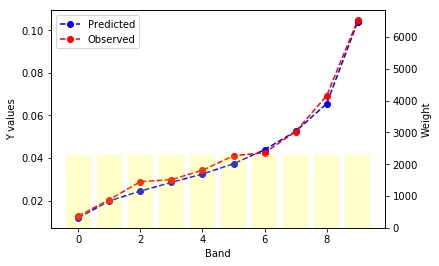

In [167]:
model = PoissonImplicitSGD(g)

iterations = 10000000
e_train = []
e_test = []
gini = []
ldeviance = []

coeffs = model.coeffs.copy()
intercept = 0

for i in range(1, 200000):
    model.fit_observation(*g.get_observation(), learning_rate=i**-0.5)

model.coeffs = coeffs / (199999)    
model.intercept = intercept / 199999
    
coeffs = model.coeffs.copy()
intercept = 0

for i in range(1, iterations + 1):
    #model.fit_all(g, learning_rate=0.3)
    model.fit_observation(*g.get_observation(), learning_rate=0.001) #i**-0.3)
    coeffs += model.coeffs
    intercept += model.intercept
    if i % 100000 == 0 :
        mstar = PoissonImplicitSGD(g)
        mstar.coeffs = coeffs / iterations
        mstar.intercept = intercept / iterations
        y, y_pred, exposure = g.pred(mstar)
        e_train.append(perf.root_mean_square_error(y, y_pred))
        e_test.append(0)
        gini.append(metrics.gini_emblem_fast(y, y_pred, exposure))
        ldeviance = np.log(metrics.poisson_deviance(y, y_pred, exposure))
        print('iteration: ', i)
        print('mean:', np.mean(y_pred/exposure) / np.mean(y/exposure), np.mean(y_pred/exposure), np.mean(y/exposure))
        print('rmse:', e_train[-1] , e_test[-1])
        print('gini:', gini[-1])
        print('deviance:', ldeviance)
        print('------------')

mstar = PoissonImplicitSGD(g)
mstar.coeffs = coeffs / i
mstar.intercept = intercept / i 

model = mstar
        
for i in range(1, 1000 + 1):
    model.fit_all(g, learning_rate=0.3)
    y, y_pred, exposure = g.pred(model)
    e_train.append(perf.root_mean_square_error(y, y_pred))
    e_test.append(0)
    gini.append(metrics.gini_emblem_fast(y, y_pred, exposure))
    ldeviance = np.log(metrics.poisson_deviance(y, y_pred, exposure))
    print('iteration: ', i)
    print('mean:', np.mean(y_pred/exposure) / np.mean(y/exposure), np.mean(y_pred/exposure), np.mean(y/exposure))
    print('rmse:', e_train[-1] , e_test[-1])
    print('gini:', gini[-1])
    print('deviance:', ldeviance)
    print('------------')
metrics.plot_lift_curve(y, y_pred, exposure)

In [148]:
for i in range(1, 1000 + 1):
    model.fit_all(g, learning_rate=0.01)
    if i % 5 == 0:
        y, y_pred, exposure = g.pred(model)
        e_train.append(perf.root_mean_square_error(y, y_pred))
        e_test.append(0)
        gini.append(metrics.gini_emblem_fast(y, y_pred, exposure))
        ldeviance = np.log(metrics.poisson_deviance(y, y_pred, exposure))
        print('iteration: ', i)
        print('mean:', np.mean(y_pred/exposure) / np.mean(y/exposure), np.mean(y_pred/exposure), np.mean(y/exposure))
        print('rmse:', e_train[-1] , e_test[-1])
        print('gini:', gini[-1])
        print('deviance:', ldeviance)
        print('------------')
metrics.plot_lift_curve(y, y_pred, exposure)

iteration:  5
mean: 1.00274767967 0.0428315492805 0.0427141843843
rmse: 0.20028101211 0
gini: 0.313224607721
deviance: 8.70264093401
------------
iteration:  10
mean: 1.00274770918 0.0428315505407 0.0427141843843
rmse: 0.200281012272 0
gini: 0.313224950195
deviance: 8.70264094456
------------
iteration:  15
mean: 1.00274773866 0.0428315518001 0.0427141843843
rmse: 0.200281012435 0
gini: 0.313225394774
deviance: 8.70264095511
------------
iteration:  20
mean: 1.00274776813 0.0428315530587 0.0427141843843
rmse: 0.200281012597 0
gini: 0.313224637077
deviance: 8.70264096566
------------
iteration:  25
mean: 1.00274779757 0.0428315543164 0.0427141843843
rmse: 0.200281012759 0
gini: 0.313224433946
deviance: 8.70264097621
------------
iteration:  30
mean: 1.002747827 0.0428315555733 0.0427141843843
rmse: 0.200281012921 0
gini: 0.313224469451
deviance: 8.70264098676
------------
iteration:  35
mean: 1.00274785641 0.0428315568294 0.0427141843843
rmse: 0.200281013082 0
gini: 0.313224680123
devia

KeyboardInterrupt: 

In [ ]:
print('intercept:', np.exp(mstar.intercept))
for k, v in zip(g.modalities, np.exp(model.coeffs)):
    print(k, ':', v)

iteration:  100
mean: 1.0
rmse: 0.202192295991
gini: 0.129138805251
deviance: 8.75618817866


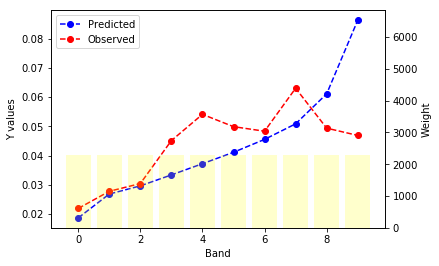

In [134]:
y_pred = np.mean(y)/np.mean(y_pred)*y_pred
print('iteration: ', i)
print('mean:', np.mean(y_pred) / np.mean(y))
print('rmse:', perf.root_mean_square_error(y, y_pred))
print('gini:', metrics.gini_emblem_fast(y, y_pred, exposure))
print('deviance:', np.log(metrics.poisson_deviance(y, y_pred, exposure)))
metrics.plot_lift_curve(y, y_pred, exposure)

In [25]:
np.mean(y_pred),np.mean(y)

(0.038934038934038934, 0.038934038934038934)

In [830]:
np.log(np.mean(y_pred)),np.log(np.mean(y))

(-3.461337782982655, -3.4556535674582141)

In [540]:
%%timeit
g.get_observation()

The slowest run took 22.91 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 2.67 µs per loop


In [ ]:
for i in range(100):
    x, y, exposure = g.get_observation()
    y_pred = model.pred(x, exposure)
    print(x, y, y_pred, exposure)

In [96]:
%%timeit
g.pred(mstar)

10 loops, best of 3: 27.5 ms per loop


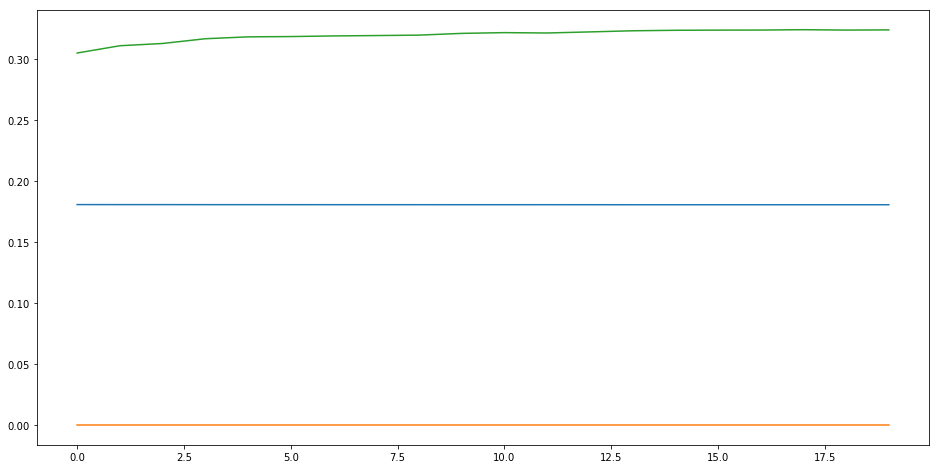

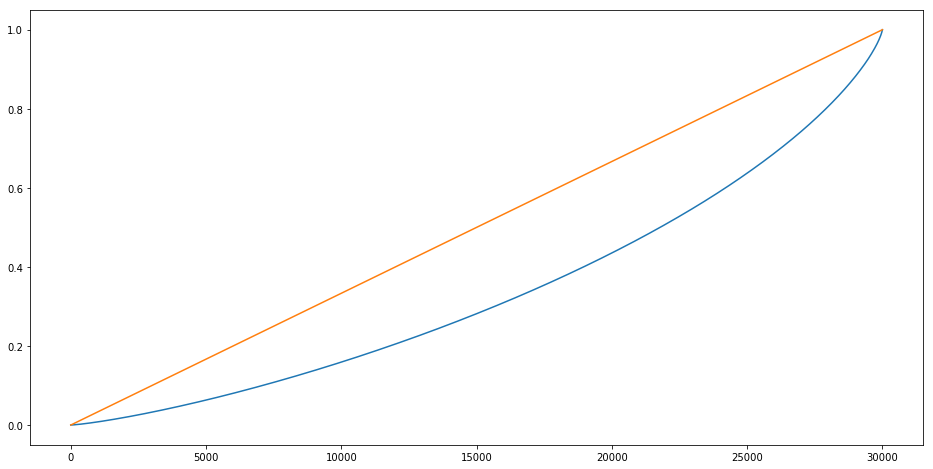

In [779]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
line, = ax.plot(e_train)
ax = fig.add_subplot(111)
line, = ax.plot(e_test)
ax = fig.add_subplot(111)
line, = ax.plot(gini)
plt.show()
perf.plot_gini(y_pred, exposure)